# Time Series Forecast - ARIMA

### Kumar Rahul

Forecasting the demand of services or products leads to better management of short term or long term planning. In this case, we are looking at the warranty related issues reported, on a particular brand of two-wheeler. The data is a monthly roll-up of approximately half a million issues reported by the customers over a four year period. 
We will be using Claim forecasting data in this exercise. Refer the **Exhibit 1** to understand the feature list. Use the data and answer the below questions.

1.	Load the time series dataset in Jupyter Notebook using pandas.
2.	Test stationarity of data using augmented dickey fuller test.
3.	Use data differencing as a strategy to make the data stationary.
4.	Plot the ACF and PACF plot. How will you inspect the plot to arrive at the p-lags and q-lags?
5.	Split the data into training set and test set. Use walk forward validation strategy for model building and evaluation.
6.	Given recent claim, what is the expected claim for the next time period? Build a model with statsmodel.api to forecast the amount claimed in next time step.
7.	Check for validity of model using ACF and PACF plot for error term. What do you observe in these plots?
8.	 How do you interpret the model outcome? Report the model performance on the walk forward validation set.

**Exhibit 1**

|Sl. No.|Name of Variable|Variable Description|
|----------|------------|---------------|
|1	|date	|Date of Claim|
|2	|rate	|Amount claimed|
|3	|item	|Number of claims|



In [1]:
import pandas as pd
import numpy as np
import warnings
from math import sqrt
from numpy import array
from matplotlib import pyplot

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [2]:
monthly_raw_df = pd.read_csv('./data/data_monthly.csv', sep=',', header=0, 
                             low_memory=False, infer_datetime_format=True, 
                             index_col=['date'], 
                             parse_dates= ['date'],dayfirst=True)

In [3]:
monthly_raw_df.sort_index(inplace=True)
monthly_raw_df.columns = monthly_raw_df.columns.str.lower().str.replace('.', '_')
monthly_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 2014-03-31 to 2017-06-30
Data columns (total 2 columns):
rate    40 non-null float64
item    40 non-null int64
dtypes: float64(1), int64(1)
memory usage: 960.0 bytes


In [4]:
monthly_raw_df.head()

,rate,item
date,,
2014-03-31,2567662.19,292008
2014-04-30,2752695.64,281420
2014-05-31,2741751.40,332925
2014-06-30,2459090.22,293740
2014-07-31,2913370.48,382901


The data for the first day and last day of CGM monitoring being trucated as it has not been captured for the full cycle.

In [5]:
monthly_filter_df = monthly_raw_df.filter(['rate'], axis =1)
#monthly_filter_df['rate'] = monthly_filter_df['rate'].map(lambda x:str(x).replace(',', '')).astype(float)

In [6]:
monthly_filter_df = monthly_filter_df[(monthly_filter_df.index >='2014-03-01') & 
                                      (monthly_filter_df.index <= '2017-05-31')]

monthly_filter_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2014-03-31 to 2017-05-31
Data columns (total 1 columns):
rate    39 non-null float64
dtypes: float64(1)
memory usage: 624.0 bytes


## Problem Framing


We will use the data to explore a very specific question; that is:

**Given recent claim, what is the expected claim for the next time period?**

Plot of the original data is shown below:

/Users/Rahul/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Monthly amount claimed over a 3 year period')

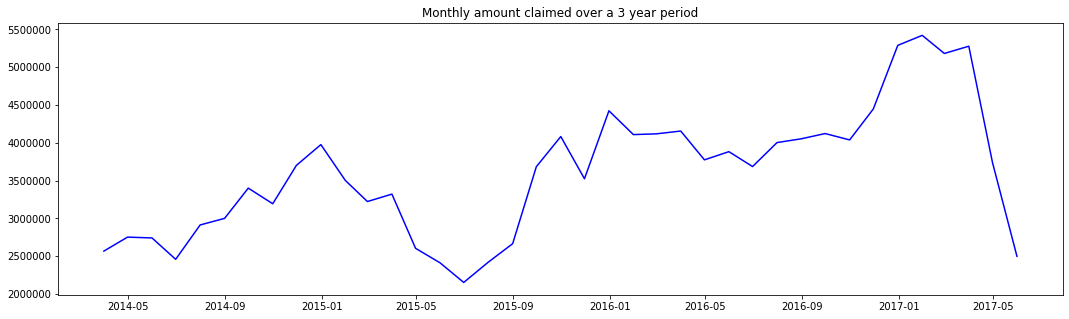

In [7]:
pyplot.figure(figsize = (18, 5))
pyplot.plot(monthly_filter_df, 'b-')
pyplot.title('Monthly amount claimed over a 3 year period')

## Stationarity

We can assume the series to be stationary if it has constant statistical properties over time, i.e. the following:

> 1. constant mean - The mean of the series should not be a function of time rather should be a constant. 
2. constant variance - The variance of the series should not a be a function of time. This property is known as homoscedasticity. 
3. an autocovariance that does not depend on time - The covariance of the i th term and the (i + m) th term should not be a function of time.

More formally, we can check stationarity using the following:

> Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.


The below function which takes a timeseries data as input and perform the Dickey-Fuller test to check stationarity: 

In [9]:
from statsmodels.tsa.stattools import adfuller
def df_test(data):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(data.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [10]:
df_test(monthly_filter_df)

Results of Dickey-Fuller Test:
Test Statistic                 -3.278250
p-value                         0.015879
#Lags Used                      3.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


Since the p-vlaue is not greater than the 5% or 10% cofidence level, suggests that the timeseries is stationary. As the series is statioanry, differencing may not be required. 

### Make time series stationary

There are 2 major reasons behind non-stationarity of a time series data:

> * Trend – varying mean over time. In this case we can see that on average, the claim is varying  over time.
* Seasonality – variations at specific time-frames. In this case, claim might be high during some time period owing to climatic conditions leading to wear and tear.


The underlying principle is to estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on the filtered series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

### Identify and Eliminate Trend and Seasonality

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Two widely used techniques of removing trend and seasonality:

> * Differencing – taking the differece with a particular time lag
* Decomposition – modeling both trend and seasonality and removing them from the model. We will not be discussing this technique

#### Differencing
One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, the difference of the observation at a particular instant with that at the previous instant is taken. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

(38, 1)

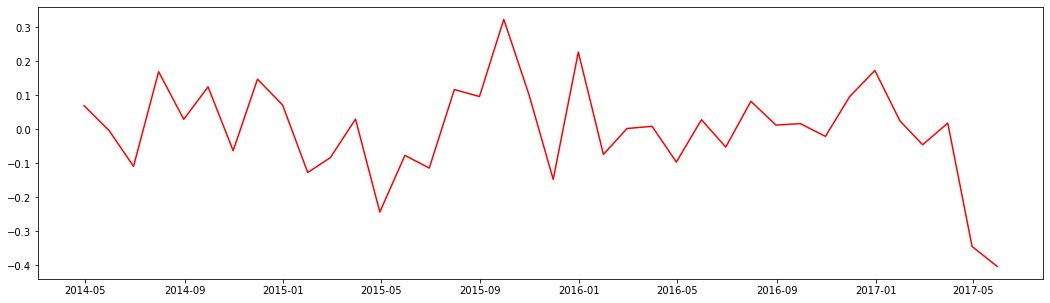

In [11]:
monthly_filter_log_df = np.log(monthly_filter_df)
monthly_filter_log_diff_df = monthly_filter_log_df - monthly_filter_log_df.shift(1)

pyplot.figure(figsize = (18, 5))
diff = pyplot.plot(monthly_filter_log_diff_df, color='red',label='Difference')
monthly_filter_log_diff_df.dropna(inplace=True)
monthly_filter_log_diff_df.shape

This appears to have reduced trend considerably. Same is evident in the plot and test below:

In [12]:
df_test(monthly_filter_log_diff_df)

Results of Dickey-Fuller Test:
Test Statistic                 -4.072928
p-value                         0.001073
#Lags Used                      0.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


We can try second order and third order differencing to further remove the variation. Since for this dataset, the time series is stationary we can set d = 0 and will find the value of p and q using ACF and PACF plot.

## Autocorrelation Analysis

We can assume the distribution of each variable fits a Gaussian (bell curve) distribution. If this is the case, we can use the Pearson’s correlation coefficient to summarize the correlation between the variables.

The Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram, or an autocorrelation plot.

A partial autocorrelation function or PACF is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. This is the intuition for the partial autocorrelation.

We can calculate autocorrelation and partial autocorrelation plots using the plot_acf() and plot_pacf() statsmodels functions respectively.

ACF and PACF plot for the monthly data

In [17]:
?plot_acf

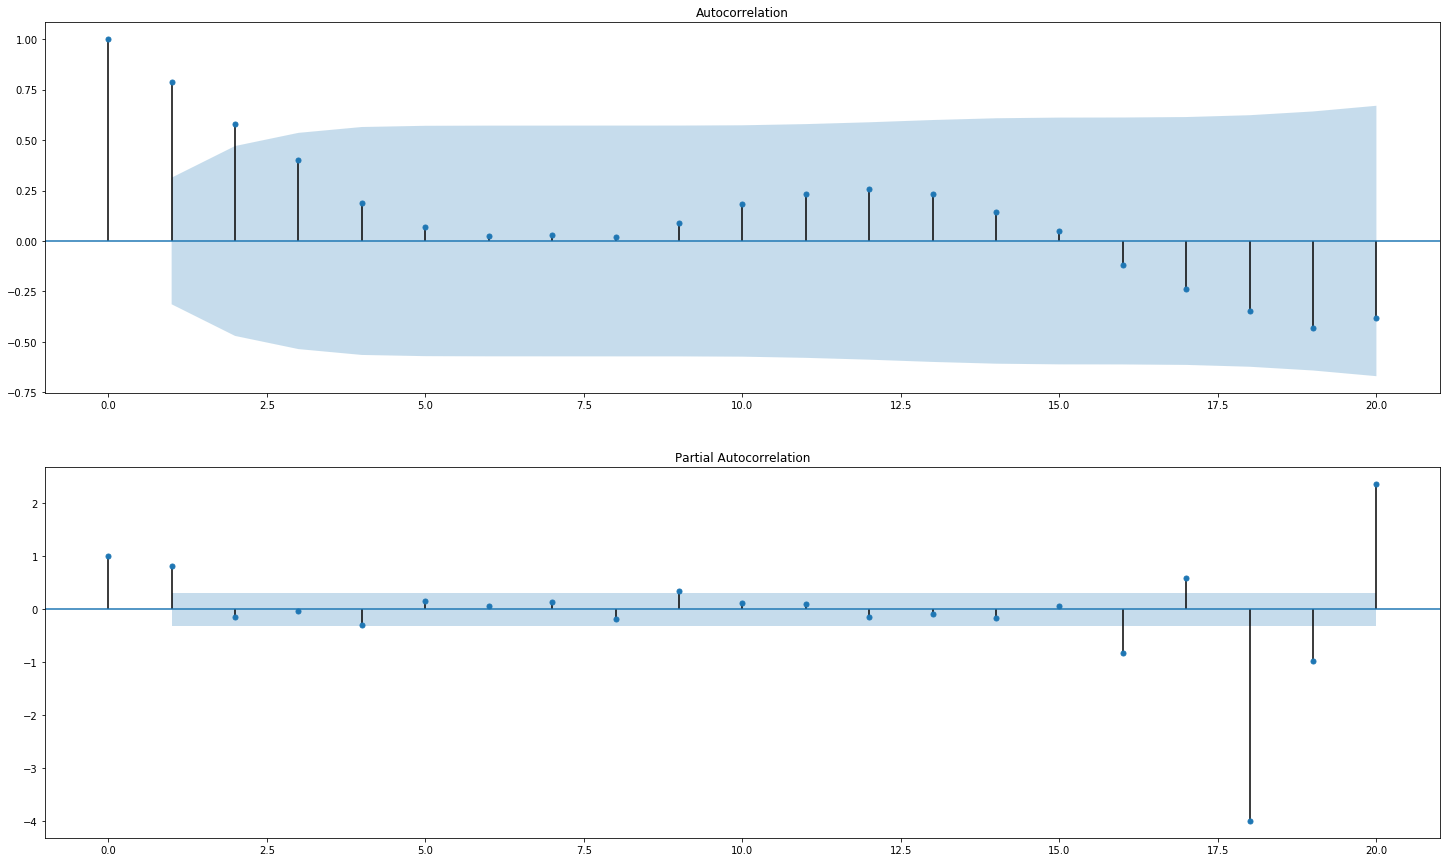

In [16]:
# plots
pyplot.figure(figsize = (25, 15))
lags = 20
# acf
axis = pyplot.subplot(2, 1, 1)
plot_acf(monthly_filter_df, ax=axis, lags=lags)
# pacf
axis = pyplot.subplot(2,1,2)
plot_pacf(monthly_filter_df, ax=axis, lags=lags)
# show plot
pyplot.show()

## Train and Test Sets
We will use the first three years of data for training predictive models and the final year for evaluating models.

The function split_filter_df() below splits the monthly data into train and test sets and organizes each into standard weeks.

Specific row offsets are used to split the data using knowledge of the filter_df. The split filter_dfs are then organized into  data using the NumPy split() function.

In [18]:
def split_filter_df(data):
    split_point = len(data) - 10
    train, test = data[0:split_point], data[split_point:]
    return train, test

In [19]:
# load the new file
train, test = split_filter_df(monthly_filter_df)

In [20]:
# validate train data
print(train.shape)
train.head()

(29, 1)


,rate
date,
2014-03-31,2567662.19
2014-04-30,2752695.64
2014-05-31,2741751.40
2014-06-30,2459090.22
2014-07-31,2913370.48


In [21]:
# validate test data
print(test.shape)
test.head()

(10, 1)


,rate
date,
2016-08-31,4053456.16
2016-09-30,4122453.71
2016-10-31,4037928.80
2016-11-30,4447380.34
2016-12-31,5288493.84


## Evaluation Metric

Both Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) can be used. Unlike MAE, RMSE is more punishing of forecast errors.

The function evaluate_forecasts_rmse() and evaluate_forecasts_mape() is being used for evaluating model performance.

In [22]:
# evaluate one or more  forecasts against expected values
def evaluate_forecasts_rmse(actual):
    score_rmse = 0
    se = 0
    # calculate an RMSE score for each day
    for i in range(actual.shape[0]):
        # calculate mse
        se += (actual.iloc[i,0] - actual.iloc[i,1])**2
        # calculate rmse
    score_rmse = sqrt(se/actual.shape[0])
    return score_rmse

In [23]:
# evaluate one or more  forecasts against expected values
def evaluate_forecasts_mape(actual):
    score_mape = 0
    ape = 0
    for i in range(actual.shape[0]):
        # calculate mse
        ape += np.abs(((actual.iloc[i,0] - actual.iloc[i,1])/actual.iloc[i,0]))
        # calculate mape
    score_mape = (ape)/actual.shape[0]
    return actual, score_mape

## Walk-Forward Validation
Models will be evaluated using a scheme called walk-forward validation.

This is where a model is required to make a one month prediction, then the actual data for that month is made available to the model so that it can be used as the basis for making a prediction on the subsequent month. This is both realistic for how the model may be used in practice and beneficial to the models, allowing them to make use of the best available data.

A walk-forward validation, or rolling forecast, method is used as follows:

> * Each time step in the test dataset is iterated.
* Within each iteration, a new ARIMA model is trained on all available historical data.
* The model is used to make a prediction for the next time step.
* The prediction is stored and the “real” observation is retrieved from the test set and added to the history for use in the next iteration.
* The performance of the model is summarized at the end by calculating the root mean squared error (RMSE) of all predictions made compared to expected values in the test dataset.


The name of a function is provided for the model as the argument “model_func“. This function is responsible for defining the model, fitting the model on the training data, and making a one-week forecast.

The forecasts made by the model are then evaluated against the test dataset using the previously defined evaluate_forecasts() function.

In [24]:
# evaluate a single model
def evaluate_model(model_func, train, test, order):
    # history is a list of  data
    history = train.filter(['rate'], axis = 1)
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history, order)
        # store the predictions
        predictions.append(yhat_sequence)      
        # get real observation and add to history for predicting the next week
        history = history.append(test.iloc[[i]])
    predictions = array(predictions)
    test['prediction'] = predictions
    # evaluate predictions days for each week
    actual, score_mape = evaluate_forecasts_mape(test[:])
    score_rmse = evaluate_forecasts_rmse(test[:])
    return actual, score_mape, score_rmse

## Develop an Autoregression Model
We can develop an autoregression model for univariate series of monthly claims.

The Statsmodels library provides multiple ways of developing an AR model, such as using the AR, ARMA, ARIMA, and SARIMAX classes.

We will use the ARIMA implementation as it allows for easy expandability into differencing and moving average.

Note: To make holts winter model, use:

> * `import statsmodels.tsa.holtwinters as hw`
* `model = hw.ExponentialSmoothing()`

Help on the model - hw.ExponentialSmoothing.fit?

In [25]:
# arima forecast
def arima_forecast(history, pdq):
    # define the model
    model = ARIMA(history, order=pdq)
    # fit the model
    model_fit = model.fit(trend = 'nc',disp=0)
    # make forecast
    yhat = model_fit.forecast(steps=1)[0]
    return yhat

In [26]:
def del_column(test):
    for n in test.columns:
        if n =='prediction':
            test.drop('prediction', axis = 1, inplace=True)  

In [27]:
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast

import itertools
p_values = [0,1,2]
d_values  = [0, 1]
q_values = [0, 1, 2]

pdq = list(itertools.product(p_values, d_values, q_values))
warnings.filterwarnings("ignore")
# evaluate each model
for name, func in models.items():
    best_mape,best_rmse, best_cfg = float("inf"), float("inf"), None
    for pdq in pdq:
        order = pdq
        del_column(test)
        try:
            actual, score_mape, score_rmse= evaluate_model(func, train, test, pdq)
            if score_rmse < best_rmse:
                best_rmse, best_mape, best_cfg = score_rmse, score_mape, order
            print('ARIMA%s MAPE=%.5f RMSE=%.4f' % (order,score_mape,score_rmse))
        except:
            continue
    print('Best ARIMA%s MAPE=%.5f RMSE=%.5f' % (best_cfg,best_mape, best_rmse))

ARIMA(0, 0, 1) MAPE=0.48689 RMSE=2240440.6176
ARIMA(0, 1, 1) MAPE=0.13356 RMSE=712904.5216
ARIMA(0, 1, 2) MAPE=0.13948 RMSE=734687.9492
ARIMA(1, 0, 0) MAPE=0.12999 RMSE=692237.5554
ARIMA(1, 1, 0) MAPE=0.13456 RMSE=716990.4978
ARIMA(2, 1, 0) MAPE=0.13487 RMSE=717861.7173
ARIMA(2, 1, 1) MAPE=0.13527 RMSE=719644.1259
Best ARIMA(1, 0, 0) MAPE=0.12999 RMSE=692237.55542


In [28]:
models = dict()
models['arima'] = arima_forecast

# evaluate each model
for name, func in models.items():
    pdq = (1,0,0)
    del_column(test)
    actual, score_mape, score_rmse= evaluate_model(func, train, test, pdq)
    print('ARIMA%s MAPE=%.5f RMSE=%.4f' % (pdq,score_mape,score_rmse))

ARIMA(1, 0, 0) MAPE=0.12999 RMSE=692237.5554


In [29]:
actual

,rate,prediction
date,,
2016-08-31,4053456.16,3.973717e+06
2016-09-30,4122453.71,4.025338e+06
2016-10-31,4037928.80,4.095398e+06
2016-11-30,4447380.34,4.011666e+06
2016-12-31,5288493.84,4.421660e+06
2017-01-31,5420980.66,5.288494e+06
2017-02-28,5181408.87,5.420981e+06
2017-03-31,5277467.13,5.155851e+06
2017-04-30,3739654.03,5.252872e+06


In [30]:
score_mape

0.12999153617138778

Coversion is needed only if the train data was log transformed. If not transformed then we can directly compute the error.

In [ ]:
actual['converted_rate'] = np.exp(actual.rate)
actual

In [ ]:
actual['converted_forecast'] = np.exp(actual.prediction)

In [ ]:
ape = 0
se=0
for i in range(actual.shape[0]):
        # calculate mse
        ape += np.abs(((np.exp(actual.iloc[i,0]) - np.exp(actual.iloc[i,1]))/np.exp(actual.iloc[i,0])))
        # calculate mape
        se += (np.exp(actual.iloc[i,0]) - np.exp(actual.iloc[i,1]))**2
        # calculate rmse
                       
score_mape = (ape)/actual.shape[0]
score_rmse = sqrt(se/actual.shape[0])

In [ ]:
score_mape

In [ ]:
score_rmse

In [32]:
actual

,rate,prediction
date,,
2016-08-31,4053456.16,3.973717e+06
2016-09-30,4122453.71,4.025338e+06
2016-10-31,4037928.80,4.095398e+06
2016-11-30,4447380.34,4.011666e+06
2016-12-31,5288493.84,4.421660e+06
2017-01-31,5420980.66,5.288494e+06
2017-02-28,5181408.87,5.420981e+06
2017-03-31,5277467.13,5.155851e+06
2017-04-30,3739654.03,5.252872e+06


In [33]:
actual['error']= actual.rate-actual.prediction

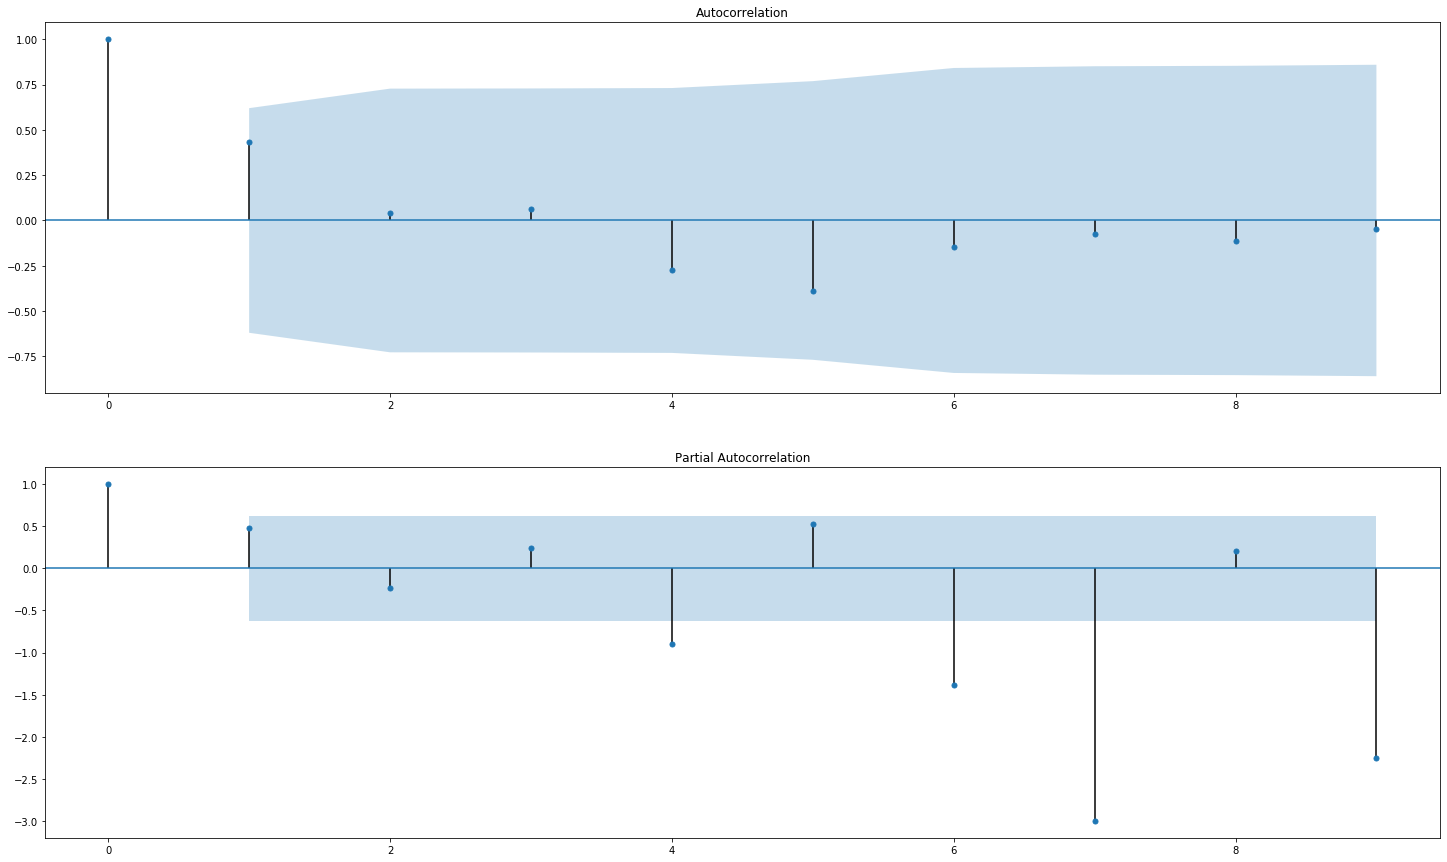

In [34]:
# plots
pyplot.figure(figsize = (25, 15))
lags = 9
# acf
axis = pyplot.subplot(2, 1, 1)
plot_acf(actual.error, ax=axis, lags=lags)
# pacf
axis = pyplot.subplot(2,1,2)
plot_pacf(actual.error, ax=axis, lags=lags)
# show plot
pyplot.show()

In [ ]:
#actual.to_csv('monthly_forecast.csv')